# Synchrony Datathalon 2025

## Load the data

In [13]:
import pandas as pd
import numpy as np

# Load all the datasets
account_df = pd.read_csv('data/account_dim_20250325.csv')
fraud_case_df = pd.read_csv('data/fraud_claim_case_20250325.csv')
fraud_tran_df = pd.read_csv('data/fraud_claim_tran_20250325.csv')
rams_df = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_df = pd.read_csv('data/statement_fact_20250325.csv')
syfid_df = pd.read_csv('data/syf_id_20250325.csv')
transaction_df = pd.read_csv('data/transaction_fact_20250325.csv')
wrld_transaction_df = pd.read_csv('data/wrld_stor_tran_fact_20250325.csv')


## Pre Process functions

In [14]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

In [15]:
# Function to clean the account dataset
def pre_process_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1. Currently it has the following values: 0, 7, 8 and nan. 0 mean activated and the rest are not activated.
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column. Currently it has the following values: H, Y and empty/na/null. Y mean employee, H means high spending customer and empty/na/null means normal customer. I want a separate column for high spending customer and employee. The rest are normal customers.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

In [16]:
def clean_transaction_data(transaction_df):

    df = transaction_df.copy()

    uselss_column=[
                'payment_type',
                'transaction_return_cnt',
                'transaction_sale_cnt',
                'product_amt',
                'product_qty',
                'invoice_nbr',
                'first_purchase_ind',
                'adj_orgn_tran_dt',
                'curr_markup_fee',
                'fcr_amount',
                'fcr_flag',
                'fcr_rate_of_exchange',
                'posting_date']
    
    #drop the useless columns
    df.drop(uselss_column,axis=1,inplace=True)

    return df

## Apply all the preprocessing

In [17]:
updated_rams_df = clean_rams(rams_df)
updated_accounts_df = pre_process_accounts(account_df)
updated_transaction_df=clean_transaction_data(transaction_df)
updated_world_transaction_df=clean_transaction_data(wrld_transaction_df)

/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_7259/823880188.py:24: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_7259/823880188.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipyke

In [18]:
# Appened transaction_df and wrld_transaction_df
combined_transaction_df = pd.concat([updated_transaction_df, updated_world_transaction_df], ignore_index=True)
transaction_sales_df = combined_transaction_df[(combined_transaction_df['transaction_type'] == 'SALE') & (combined_transaction_df['transaction_code'] == 253)]

## EDA

/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_7259/1813184487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])


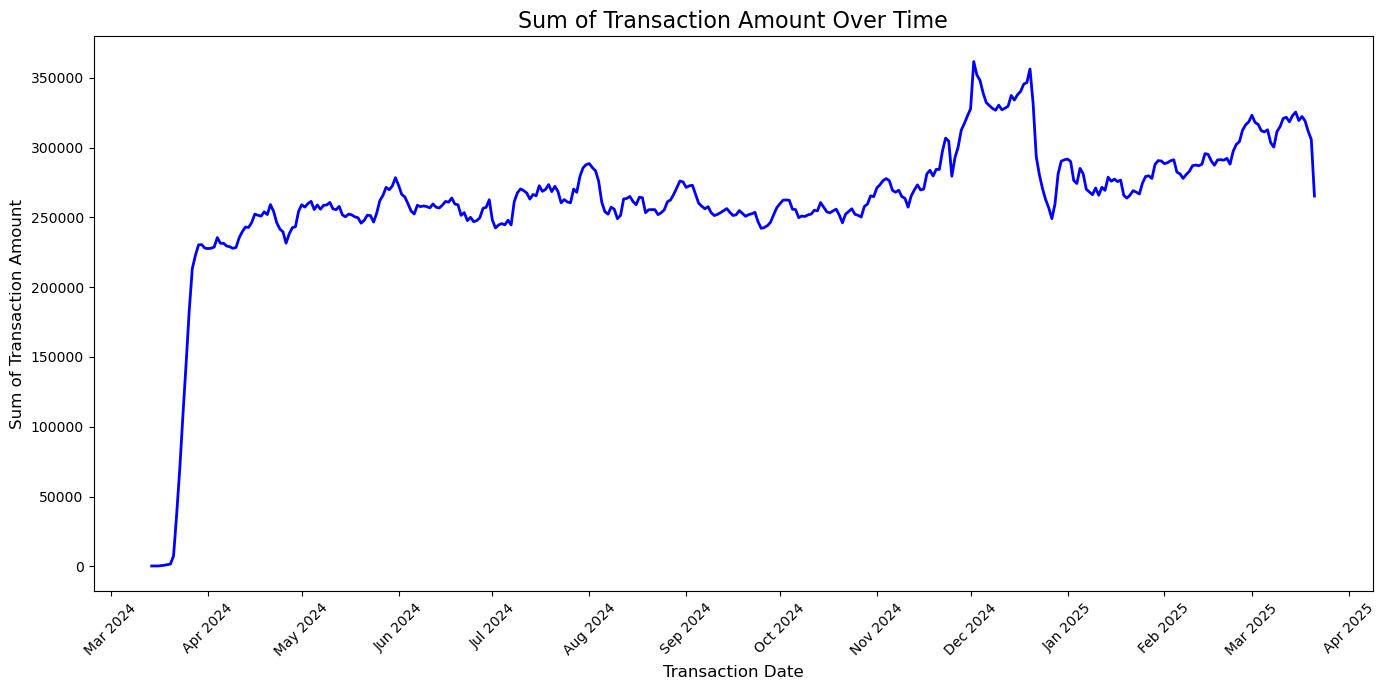

In [19]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Calculate the sum of transaction amounts grouped by transaction date
transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])
transaction_sum = transaction_sales_df.groupby('transaction_date')['transaction_amt'].sum()

# Filter data to start from March 2024
transaction_sum_filtered = transaction_sum[transaction_sum.index >= '2024-03-01']

transaction_sum_smoothed = transaction_sum_filtered.rolling(window=7, center=True).mean()

# Plot the sum of transaction amounts over time
plt.figure(figsize=(14, 7))
plt.plot(transaction_sum_smoothed.index, transaction_sum_smoothed.values, color='blue', linewidth=2, label='Transaction Amount')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Sum of Transaction Amount Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Sum of Transaction Amount', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

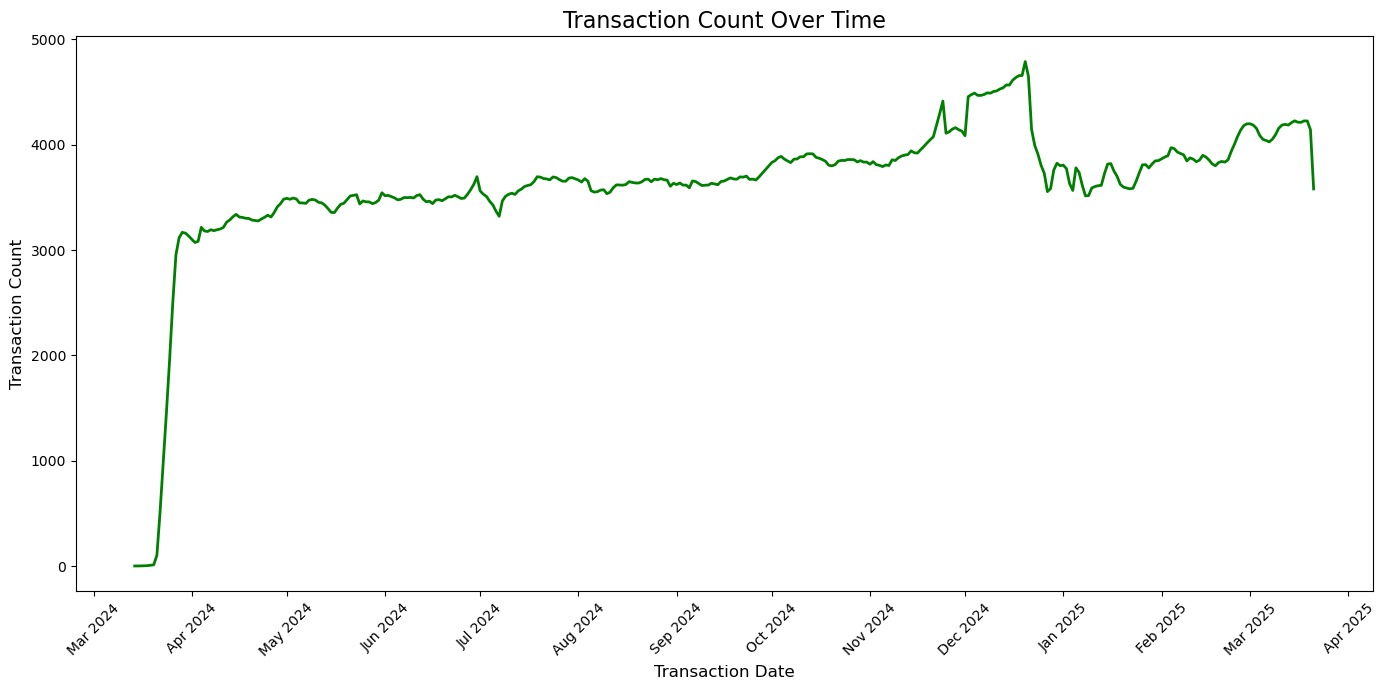

In [20]:
# Calculate the count of transactions grouped by transaction date
transaction_count = transaction_sales_df.groupby('transaction_date').size()

# Filter data to start from March 2024
transaction_count_filtered = transaction_count[transaction_count.index >= '2024-03-01']

transaction_count_smoothed = transaction_count_filtered.rolling(window=7, center=True).mean()

# Plot the transaction count over time
plt.figure(figsize=(14, 7))
plt.plot(transaction_count_smoothed.index, transaction_count_smoothed.values, color='green', linewidth=2, label='Transaction Count')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add title and labels
plt.title('Transaction Count Over Time', fontsize=16)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

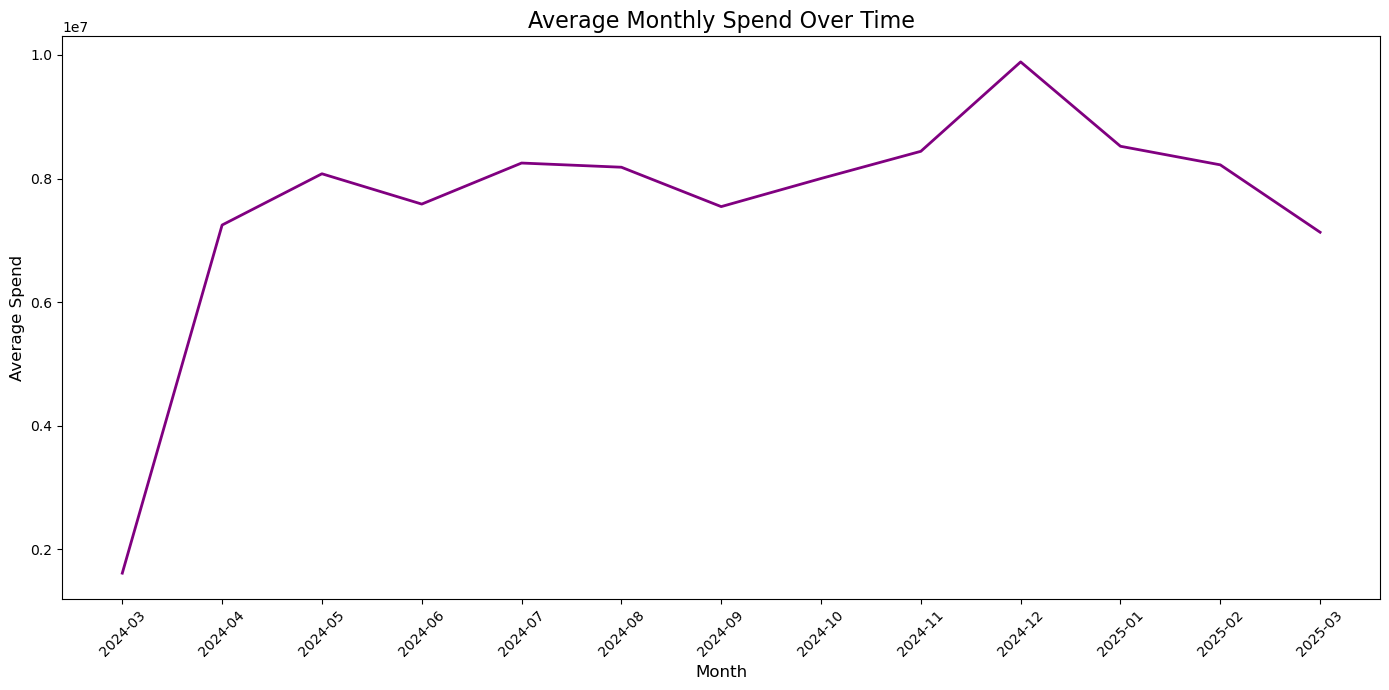

In [ ]:
# Calculate the average monthly spend
avg_monthly_spend = transaction_sales_df.groupby('current_account_nbr')['year_month'].sum()

# Filter data to start from March 2024
avg_monthly_spend_filtered = avg_monthly_spend[avg_monthly_spend.index >= '2024-03']

# Plot the average monthly spend
plt.figure(figsize=(14, 7))
plt.plot(avg_monthly_spend_filtered.index.astype(str), avg_monthly_spend_filtered.values, 
         color='purple', linewidth=2, label='Average Monthly Spend')

# Format the x-axis
plt.xticks(rotation=45)

# Add title and labels
plt.title('Average Monthly Spend Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Spend', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


# Generate Forecasting Model

In [22]:
# Convert transaction_date to datetime if not already
transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])

# Filter transactions between March 2024 and March 2025
filtered_transactions = transaction_sales_df[
    (transaction_sales_df['transaction_date'] >= '2024-03-01') &
    (transaction_sales_df['transaction_date'] <= '2025-03-31')
]

# Extract year and month from transaction_date
filtered_transactions['year_month'] = filtered_transactions['transaction_date'].dt.to_period('M')

# Group by account and count unique months
account_month_counts = filtered_transactions.groupby('current_account_nbr')['year_month'].nunique()

# Filter accounts with at least one transaction per month (13 months)
eligible_accounts = account_month_counts[account_month_counts == 13].index

# Filter the original dataframe for these accounts
filtered_accounts_df = transaction_sales_df[transaction_sales_df['current_account_nbr'].isin(eligible_accounts)]

/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_7259/3830390005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_sales_df['transaction_date'] = pd.to_datetime(transaction_sales_df['transaction_date'])
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_7259/3830390005.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transactions['year_month'] = filtered_transactions['transaction_date'].dt.to_period('M')


In [30]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

# Ensure transaction_date is in datetime format
filtered_accounts_df['transaction_date'] = pd.to_datetime(filtered_accounts_df['transaction_date'])

# Aggregate spending by month for each account
monthly_spending = filtered_accounts_df.groupby(['current_account_nbr', filtered_accounts_df['transaction_date'].dt.to_period('M')])['transaction_amt'].sum().reset_index()
monthly_spending.rename(columns={'transaction_date': 'year_month'}, inplace=True)

# Forecast spending for Q4 for each account
q4_predictions = {}
for account in monthly_spending['current_account_nbr'].unique():
    account_data = monthly_spending[monthly_spending['current_account_nbr'] == account]
    account_data.set_index('year_month', inplace=True)
    account_data = account_data['transaction_amt'].asfreq('M').fillna(0)  # Ensure monthly frequency and fill missing months with 0

    # Use only the last 8 months of the current year and past years' data
    train_data = account_data[:-8]

    # Fit ARIMA model
    try:
        model = ARIMA(train_data, order=(1, 1, 1))  # Adjust ARIMA order as needed
        model_fit = model.fit()

        # Forecast for Q4 (October, November, December)
        forecast = model_fit.forecast(steps=3)
        q4_predictions[account] = forecast.values
    except Exception as e:
        print(f"ARIMA model failed for account {account}: {e}")
        q4_predictions[account] = [np.nan, np.nan, np.nan]

# Convert Q4 predictions to a DataFrame
q4_predictions_df = pd.DataFrame.from_dict(q4_predictions, orient='index', columns=['Oct_2025', 'Nov_2025', 'Dec_2025'])
q4_predictions_df.reset_index(inplace=True)
q4_predictions_df.rename(columns={'index': 'current_account_nbr'}, inplace=True)

# Display the predictions
print(q4_predictions_df)

/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_7259/4235194920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_accounts_df['transaction_date'] = pd.to_datetime(filtered_accounts_df['transaction_date'])
/opt/anaconda3/envs/datascience_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/datascience_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregres

     current_account_nbr     Oct_2025      Nov_2025     Dec_2025
0       00iP5U82D8XwVQ9G   189.739891    197.700311   195.426610
1       033o9yHYen3xoz6k  1433.200855   1433.899194  1433.201660
2       049sX01uVFhaa0i2  2292.793881   2394.968114  2369.907089
3       05AfSsd6epxXiK01  7233.724983   6931.384229  7019.511849
4       05oLsFWaSLYzc5hv   683.723594    674.961497   675.596607
...                  ...          ...           ...          ...
2464    zp60CmOQNComnHDT  2372.357553  11976.787822  2372.359731
2465    zsYIael1LtCzyZNe   936.912166    893.217815   902.942132
2466    zxn3AYXktnnqqYRJ   413.004474    385.833716   389.551278
2467    zxwuHFEBf4ERmY9F   911.981382    820.330156   834.365357
2468    zzEuUBBmvGiVnabb  1181.997902   1083.225028  1130.267698

[2469 rows x 4 columns]


In [ ]:
# Save the predictions to a CSV file
#q4_predictions_df.to_csv('q4_predictions.csv', index=False)